In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.optimize import minimize, Bounds

In [2]:
def get_stock_data(tickers, start_date, end_date):
    """Get stock data for given tickers"""
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
        data[ticker] = stock
    return data

In [3]:
def calculate_portfolio_metrics(returns):
    """Calculate portfolio performance metrics"""
    # Annualized return
    ann_return = (1 + returns.mean()) ** 252 - 1   # 252 is assumed to be the number of trading days ( power indicates compouding effect )

    # Annualized volatility
    ann_vol = returns.std() * np.sqrt(252)

    # Sharpe ratio (assuming risk-free rate = 0.02)
    rf = 0.02
    sharpe = (ann_return - rf) / ann_vol

    # Maximum drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns - running_max) / running_max
    mdd = drawdowns.min()

    return {
        'Annual Return': ann_return,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': mdd
    }

In [12]:
start_date = '2022-01-01' 
end_date = '2024-01-01'   
oos_start = '2023-11-01'  

### Porfolios

In [9]:
# Portfolio 1 - MSCI
msci_portfolio = {
    'PDD': 0.15, 'NIO': 0.12, 'MELI': 0.12, 'SE': 0.12,
    'VALE': 0.12, 'PBR': 0.12, 'HDB': 0.10, 'INFY': 0.08, 'ITUB': 0.07
}

# Portfolio 2 - Tech Giants
tech_portfolio = {
    'MSFT': 0.4, 'AAPL': 0.2, 'NVDA': 0.2, 'TSLA': 0.1, 'INTC': 0.1
}

# Portfolio 3 - Given File (with and without shorting)
file_portfolio_no_short = {
    'QLYS': 0.057609, 'AVGO': 0.381013, 'GD': 0, 'NOC': 0.220735,
    'CSCO': 0, 'PANW': 0, 'CRWD': 0, 'FTNT': 0.22171,
    'ZS': 0.014374, 'NET': 0.10456
}

file_portfolio_with_short = {
    'QLYS': 0.32608, 'AVGO': 0.717236, 'GD': 0.49931, 'NOC': 0.399583,
    'CSCO': -1.133837, 'PANW': -0.066538, 'CRWD': -0.365692, 'FTNT': 0.265119,
    'ZS': 0.23403, 'NET': 0.124704
}


In [10]:
def calculate_portfolio_returns(data, weights):
    """Calculate portfolio returns given price data and weights"""
    returns = data.pct_change()
    portfolio_returns = (returns * weights).sum(axis=1)
    return portfolio_returns

def run_portfolio_analysis():
    # Get data for all portfolios
    msci_tickers = list(msci_portfolio.keys())
    tech_tickers = list(tech_portfolio.keys())
    file_tickers = list(file_portfolio_no_short.keys())

    # deal tickers
    all_tickers = list(set(msci_tickers + tech_tickers + file_tickers))

    # Get price data for each tickers
    data = get_stock_data(all_tickers, start_date, end_date)

    # Calculate returns for each 4 portfolios
    portfolios = {
        'MSCI Markets': (msci_portfolio, data[msci_tickers]),
        'Tech Giants': (tech_portfolio, data[tech_tickers]),
        'File No Short': (file_portfolio_no_short, data[file_tickers]),
        'File With Short': (file_portfolio_with_short, data[file_tickers])
    }

    # Store results in dict
    results = {}
    equity_curves = pd.DataFrame()

    for name, (weights, price_data) in portfolios.items():
        # Calculate portfolio returns
        returns = calculate_portfolio_returns(price_data, weights)

        # Split into in-sample and out-of-sample
        returns_is = returns[returns.index < oos_start]
        returns_oos = returns[returns.index >= oos_start]

        # Calculate metrics
        metrics_is = calculate_portfolio_metrics(returns_is)
        metrics_oos = calculate_portfolio_metrics(returns_oos)

        results[f'{name} (In-Sample)'] = metrics_is
        results[f'{name} (Out-of-Sample)'] = metrics_oos

        # Calculate equity curve
        equity_curve = (1 + returns).cumprod()
        equity_curves[name] = equity_curve

    return results, equity_curves

def plot_results(equity_curves):
    plt.figure(figsize=(15, 8))
    for col in equity_curves.columns:
        plt.plot(equity_curves.index, equity_curves[col], label=col)

    plt.title('Portfolio Performance Comparison')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


Portfolio Performance Metrics:
                   MSCI Markets (In-Sample)  MSCI Markets (Out-of-Sample)  \
Annual Return                        0.3152                        0.1910   
Annual Volatility                    0.2621                        0.2121   
Sharpe Ratio                         1.1263                        0.8064   
Max Drawdown                        -0.1542                       -0.1579   

                   Tech Giants (In-Sample)  Tech Giants (Out-of-Sample)  \
Annual Return                       0.8638                       0.3965   
Annual Volatility                   0.2676                       0.2352   
Sharpe Ratio                        3.1534                       1.6007   
Max Drawdown                       -0.1692                      -0.2053   

                   File No Short (In-Sample)  File No Short (Out-of-Sample)  \
Annual Return                         0.4667                         0.5411   
Annual Volatility                     0.2320    

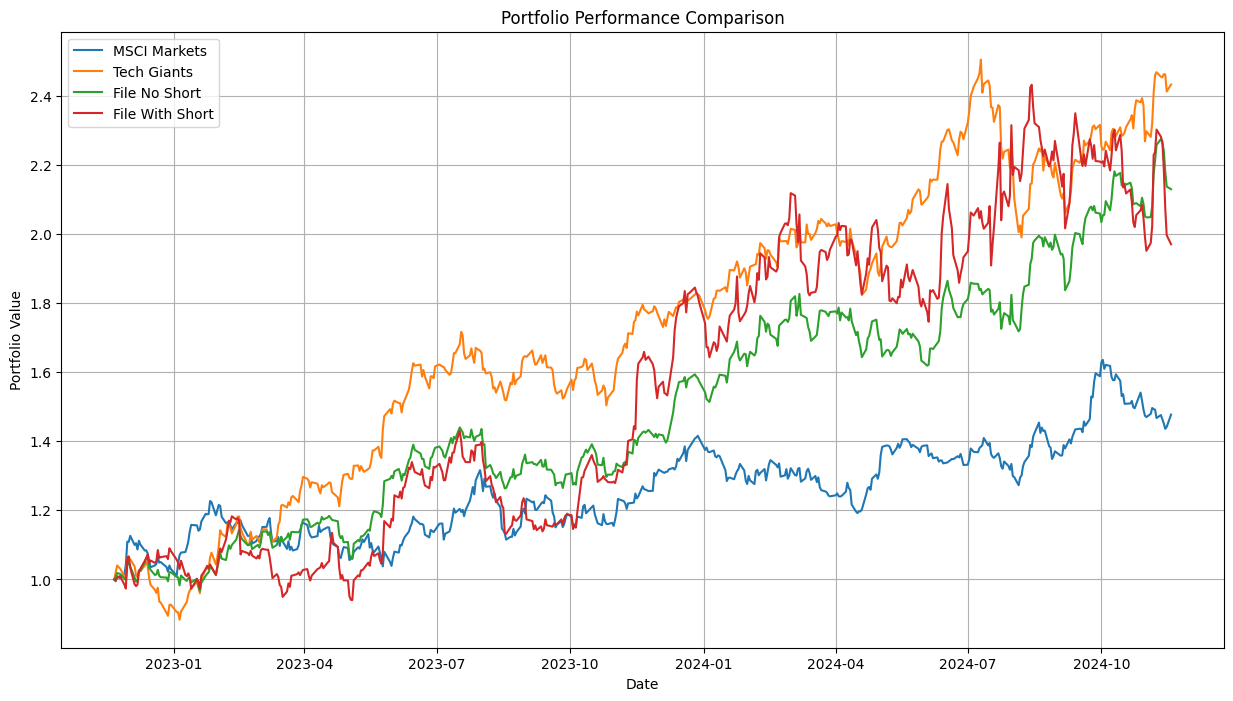

In [11]:
results, equity_curves = run_portfolio_analysis()

# Convert results to DataFrame for better display
results_df = pd.DataFrame(results).round(4)
print("\nPortfolio Performance Metrics:")
print(results_df)

# Plot equity curves
plot_results(equity_curves)

教授是直接比較GMPV,MSRP, GMPV no short sell, MSRP short sell.   
要採用多少，留多少，都看你決定。
我個人覺得可以當作最後的比較，證明前面的標的策略勝過課堂方法。

[*********************100%***********************]  10 of 10 completed


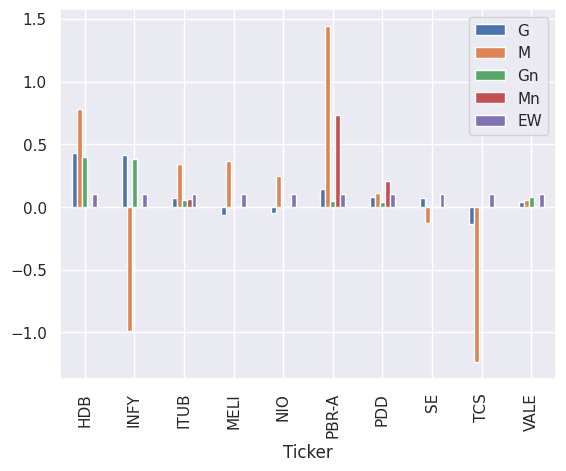

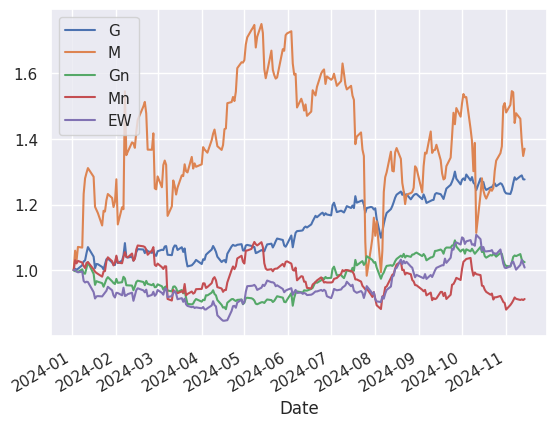

In [18]:
Ast = yf.download(['PDD', 'NIO', 'MELI', 'SE', 'VALE', 'PBR-A', 'TCS','HDB','INFY','ITUB'],
interval="1d", start="2021-12-01", end="2024-11-15")

#estimate
Ri = (Ast['Adj Close'].loc[:'2023-12-29'].resample('ME').last()
.pct_change().dropna())

#test
CRo = Ast['Adj Close'].loc['2023-12-30':'2024-11-15']
CRo = CRo/CRo.iloc[0,:]

ER, S = Ri.mean(), Ri.cov()

def PV(w, S):
  return (w.T @ S @ w)

def NPSR(w, ER, S):
  return -(w.T @ ER)/ ((w.T @ S @ w) ** 0.5)

N = len(ER)
x0 = np.ones(N)/N # initial guess with w = 1/N
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})

G = minimize(PV, x0, method='SLSQP', args=S, constraints=cons).x
M = minimize(NPSR, x0, method='SLSQP', args=(ER, S),
constraints=cons).x

bounds = Bounds(0, 1) # define no short selling constraint

Gn = minimize(PV, x0, method='SLSQP', constraints=cons, args=S,
bounds=bounds).x
Mn = minimize(NPSR, x0, method='SLSQP', args=(ER, S),
constraints=cons, bounds=bounds).x

import seaborn as sns

# Set Seaborn style
sns.set_theme()

# Assuming Ri, G, M, Gn, Mn, N, and CRo are already defined

# Create DataFrame P
P = pd.DataFrame(index=Ri.columns)

P['G'], P['M'], P['Gn'], P['Mn'], P['EW']= G, M, Gn, Mn, 1/N

fig2a = P.plot(kind='bar')
fig2b = (CRo @ P).plot()
